In [1]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Getting the data and feature engineering

In [3]:
#Creating the functiong that will get the data for us
def get_data(league):
    
    files = [file for file in listdir(f'./../raw_data/{league}')]
    data = pd.DataFrame()


    for file in files:
        df = pd.read_csv(f'./../raw_data/{league}/'+file)
        data = pd.concat([data, df])
    return data

In [4]:
data = get_data(league='turkey')

In [5]:
data.shape

(3869, 141)

In [6]:
def feature_engineering(data, b=20):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
    '''
        
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5

    # payout of betting on over 2.5 goals: we get 0 if we lose the bet, we get the AvgC if we win the bet (AvgC = market average of the odds)
    data['payout_over_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    # payout of betting on under 2.5 goals: we get 0 if we lose the bet, we get the AvgC if we win the bet (AvgC = market average of the odds)
    data['payout_under_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #Implied Probability OVER 2.5 goals for overall market (AvgC)
    data['Implied Probability >2.5']=1/data['AvgC>2.5']*100
    
    #Implied Probability UNDER 2.5 goals for overall market (AvgC)
    data['Implied Probability <2.5']=1/data['AvgC<2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365C>2.5']*100
    
    # Binning the implied probabilities with bins of 10
    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()
    
    data['binned >2.5'] = pd.cut(data['Implied Probability >2.5'], bins)
    data['binned <2.5'] = pd.cut(data['Implied Probability <2.5'], bins)
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    
    return data

In [7]:
data = feature_engineering(data)

In [8]:
data.shape

(3860, 162)

In [9]:
data['HomeTeam'].isna().sum(), data['AwayTeam'].isna().sum()

(0, 0)

In [10]:
fdf = data[['Implied Probability >2.5','over_2.5_goals','binned >2.5','payout_over_2.5']]
fdf_under = data[['Implied Probability <2.5','under_2.5_goals','binned <2.5','payout_under_2.5']]
fdf_under_365 = data[['Implied Probability <2.5 365','under_2.5_goals','binned <2.5 365','payout_under_2.5_365']]
fdf_under_pinacle = data[['Implied Probability <2.5 pinacle','under_2.5_goals','binned <2.5 pinacle','payout_under_2.5_pinacle']]
fdf_over = data[['Implied Probability >2.5','over_2.5_goals','binned >2.5','payout_over_2.5']]
fdf_over_pinacle = data[['Implied Probability >2.5 pinacle','over_2.5_goals','binned >2.5 pinacle','payout_over_2.5_pinacle']]
fdf_over_365 = data[['Implied Probability >2.5 365','over_2.5_goals','binned >2.5 365','payout_over_2.5_365']]

In [11]:
fdf.groupby('binned >2.5')['payout_over_2.5'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned >2.5,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",0,NaN,NaN,NaN
"(30, 35]",0,NaN,NaN,NaN
"(35, 40]",5,0.000,0.502000,2.51
"(40, 45]",46,2.230,1.256739,2.48


In [12]:
#group by BINS of implied probability (whole market) for < 2.5 goals --> series is the number of games
fdf_under.groupby('binned <2.5')['payout_under_2.5'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",1,0.00,0.000000,0.00
"(25, 30]",3,0.00,0.000000,0.00
"(30, 35]",14,0.00,0.233571,3.27
"(35, 40]",56,0.00,0.996964,2.85
"(40, 45]",167,0.00,0.760898,2.46


In [13]:
# Same only for 365 bookie
fdf_under_365.groupby('binned <2.5 365')['payout_under_2.5_365'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5 365,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",3,0.00,0.000000,0.00
"(25, 30]",7,0.00,0.500000,3.50
"(30, 35]",15,0.00,0.956667,2.87
"(35, 40]",49,0.00,0.744898,2.70
"(40, 45]",148,0.00,0.800000,2.40


In [14]:
fdf_under_pinacle.groupby('binned <2.5 pinacle')['payout_under_2.5_pinacle'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned <2.5 pinacle,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",2,0.00,0.000000,0.00
"(25, 30]",6,0.00,0.566667,3.40
"(30, 35]",16,0.00,1.102500,3.01
"(35, 40]",79,0.00,0.573418,2.78
"(40, 45]",187,0.00,0.990428,2.49


In [15]:
fdf_over_pinacle.groupby('binned >2.5 pinacle')['payout_over_2.5_pinacle'].agg(['count', 'median', 'mean', 'max'])

,count,median,mean,max
binned >2.5 pinacle,,,,
"(0, 5]",0,NaN,NaN,NaN
"(5, 10]",0,NaN,NaN,NaN
"(10, 15]",0,NaN,NaN,NaN
"(15, 20]",0,NaN,NaN,NaN
"(20, 25]",0,NaN,NaN,NaN
"(25, 30]",0,NaN,NaN,NaN
"(30, 35]",1,0.000,0.000000,0.00
"(35, 40]",12,0.000,1.072500,2.66
"(40, 45]",82,1.115,1.155732,2.47


In [16]:
fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle']

0      0.00
2      2.14
6      2.14
7      2.19
12     2.13
       ... 
263    2.22
272    2.02
275    0.00
279    0.00
291    2.13
Name: payout_under_2.5_pinacle, Length: 329, dtype: float64

## CLT - Central Limit Theorem Analysis

<AxesSubplot:ylabel='Count'>

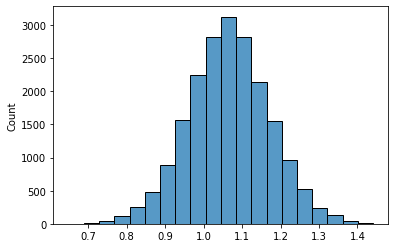

In [17]:
n = 100
N = 20000
means = [fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].sample(n, replace=True).mean() for i in range(N)]

sns.histplot(means, bins=20)

In [18]:
mu = fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].mean()
sigma = fdf_under_pinacle[fdf_under_pinacle['binned <2.5 pinacle'].astype(str)=='(45, 50]']['payout_under_2.5_pinacle'].std()

In [19]:
from scipy.stats import skew, kurtosis

# $CHALLENGIFY_BEGIN
index_df = ['mean', 'stdev', 'kurtosis', 'skewness']
theory = [mu, sigma/np.sqrt(n), 0, 0]
real_life = [np.mean(means), np.std(means), skew(means), kurtosis(means)]
comparison_df = pd.DataFrame(list(zip(theory,real_life)), 
                             columns = ["CLT Theory","Real Tips"],
                             index = index_df)
round(comparison_df,2)
# $CHALLENGIFY_END

,CLT Theory,Real Tips
mean,1.06,1.07
stdev,0.11,0.11
kurtosis,0.00,0.00
skewness,0.00,-0.00


## Analysing the numbers of a Buyuksehyr team

In [20]:
#general numbers of the team

In [21]:
buyu_df = data[(data['HomeTeam'] == 'Buyuksehyr') | (data['AwayTeam'] == 'Buyuksehyr')]
number_of_games = len(buyu_df)
total_goals = int(buyu_df[['nb_goals']].sum())
mean_goals_games = total_goals / number_of_games

In [22]:
number_of_games, total_goals, mean_goals_games

(384, 991, 2.5807291666666665)

In [23]:
buyu_df['under_2.5_goals'].value_counts()[1]

200

In [24]:
#Home numbers of the team

In [25]:
buyu_home_df = buyu_df[buyu_df['HomeTeam'] == 'Buyuksehyr']
goals_as_home = int(buyu_home_df['FTHG'].sum())
total_goals_ishome = int(buyu_home_df[['nb_goals']].sum())
total_away_goals = int(buyu_home_df['FTAG'].sum())
total_home_victory = buyu_home_df['FTR'].value_counts()[0]
total_home_draws = buyu_home_df['FTR'].value_counts()[1]
total_home_losses = buyu_home_df['FTR'].value_counts()[2]
mean_home_goals_games = total_goals_ishome / 192

In [26]:
buyu_home_df['under_2.5_goals'].value_counts()

False    101
True      91
Name: under_2.5_goals, dtype: int64

In [27]:
goals_as_home, total_away_goals, total_goals_ishome, mean_home_goals_games, total_home_victory, total_home_draws, total_home_losses

(333, 188, 521, 2.7135416666666665, 104, 54, 34)

In [28]:
buyu_home_df['FTHG'].value_counts()

1.0    59
2.0    57
0.0    31
3.0    27
4.0    11
5.0     7
Name: FTHG, dtype: int64

In [29]:
#Away numbers of the team

In [30]:
buyu_away_df = buyu_df[buyu_df['AwayTeam'] == 'Buyuksehyr']

In [31]:
goals_as_away = int(buyu_away_df['FTAG'].sum())
total_goals_isaway = int(buyu_away_df[['nb_goals']].sum())
total_thome_goals = int(buyu_away_df['FTHG'].sum())
total_away_victory = buyu_away_df['FTR'].value_counts()[0]
total_away_draws = buyu_away_df['FTR'].value_counts()[2]
total_away_losses = buyu_away_df['FTR'].value_counts()[1]
mean_away_goals_games = total_goals_isaway / 192

In [32]:
buyu_away_df['under_2.5_goals'].value_counts()

True     109
False     83
Name: under_2.5_goals, dtype: int64

In [33]:
buyu_odd_away = 1/(109/192)    
buyu_odd_away

1.7614678899082568

In [34]:
goals_as_away, total_thome_goals, total_goals_isaway, mean_away_goals_games, total_away_victory, total_away_draws, total_away_losses

(239, 231, 470, 2.4479166666666665, 75, 49, 68)

In [35]:
buyu_away_df[['nb_goals']].value_counts()

nb_goals
2.0         53
3.0         40
1.0         38
4.0         19
0.0         18
5.0         16
6.0          6
7.0          2
dtype: int64

In [36]:
buyu_away_df['FTR'].value_counts()

A    75
H    68
D    49
Name: FTR, dtype: int64

## Creating the home and away under odds feature

In [55]:
lst1 = []
lst2 = []
for i, team in enumerate(data['HomeTeam']):
    total = len(data[data['HomeTeam'] == team])
    n_under_home = data[data['HomeTeam'] == team]['under_2.5_goals'].value_counts()[1]
    lst1.append(1/(n_under_home/total))
    lst2.append(n_under_home/total)
data['odds_home_under'] = lst1
data['prob_home_under'] = lst2

In [56]:
lst3 = []
lst4  = []
for i, team in enumerate(data['AwayTeam']):
    total2 = len(data[data['AwayTeam'] == team])
    n_under_away2 = data[data['AwayTeam'] == team]['under_2.5_goals'].value_counts()[1]
    lst3.append(1/(n_under_away2 / total2))
    lst4.append(n_under_away2 / total2)
data['odds_away_under'] = lst3
data['prob_away_under'] = lst4

In [92]:
data.head(23)

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,binned >2.5 365,odds_home_under,odds_away_under,prob_home_under,prob_away_under,binned PC<2.5,PC<2.5 low odds,binned PC>2.5,binned prob_home_under,binned prob_away_under
0,T1,2017-11-08,Buyuksehyr,Bursaspor,1.0,0.0,H,1.0,0.0,H,...,NaN,2.109890,2.154930,0.473958,0.464052,NaN,False,NaN,"(45, 50]","(45, 50]"
1,T1,2017-12-08,Akhisar Belediyespor,Sivasspor,1.0,0.0,H,0.0,0.0,D,...,NaN,2.087719,2.493506,0.478992,0.401042,NaN,False,NaN,"(45, 50]","(40, 45]"
2,T1,2017-12-08,Alanyaspor,Kasimpasa,1.0,3.0,A,1.0,2.0,A,...,NaN,2.547619,2.285714,0.392523,0.437500,NaN,False,NaN,"(35, 40]","(40, 45]"
3,T1,2017-12-08,Genclerbirligi,Karabukspor,1.0,1.0,D,1.0,1.0,D,...,NaN,1.860215,3.051282,0.537572,0.327731,NaN,False,NaN,"(50, 55]","(30, 35]"
4,T1,2017-12-08,Goztep,Fenerbahce,2.0,2.0,D,1.0,1.0,D,...,NaN,2.093023,2.177083,0.477778,0.459330,NaN,False,NaN,"(45, 50]","(45, 50]"
5,T1,2017-08-13,Besiktas,Antalyaspor,2.0,0.0,H,1.0,0.0,H,...,NaN,2.612500,2.042553,0.382775,0.489583,NaN,False,NaN,"(35, 40]","(45, 50]"
6,T1,2017-08-13,Trabzonspor,Konyaspor,2.0,1.0,H,1.0,1.0,D,...,NaN,2.430233,1.923077,0.411483,0.520000,NaN,False,NaN,"(40, 45]","(50, 55]"
7,T1,2017-08-13,Yeni Malatyaspor,Osmanlispor,3.0,1.0,H,1.0,0.0,H,...,NaN,1.875000,1.961538,0.533333,0.509804,NaN,False,NaN,"(50, 55]","(50, 55]"
8,T1,2017-08-14,Galatasaray,Kayserispor,4.0,1.0,H,3.0,1.0,H,...,NaN,2.458824,2.232558,0.406699,0.447917,NaN,False,NaN,"(40, 45]","(40, 45]"
9,T1,2017-08-18,Kasimpasa,Besiktas,2.0,2.0,D,1.0,2.0,A,...,NaN,2.823529,2.177083,0.354167,0.459330,NaN,False,NaN,"(35, 40]","(45, 50]"


In [77]:
data['Date'] = pd.to_datetime(data['Date'])

nan

In [101]:
date = data['Date'].iloc[21]
data[(data['HomeTeam'] == 'Goztep') & (data['Date'] < date)]
data[(data['HomeTeam'] == 'Goztep') & (data['Date'] < date)]['under_2.5_goals'].value_counts()

False    2
Name: under_2.5_goals, dtype: int64

In [104]:
lst1 = []
lst2 = []
for i, team in enumerate(data['HomeTeam']):
    date = data['Date'].iloc[i]
    total = len(data[(data['HomeTeam'] == team) & (data['Date'] < date)])
    n_under_home = data[(data['HomeTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
    try:
        lst1.append(1/(n_under_home[1]/total))
        lst2.append(n_under_home[1]/total)
    except:
        lst1.append(np.nan)
        lst2.append(np.nan)
        
data['odds_home_under'] = lst1
data['prob_home_under'] = lst2

In [108]:
lst3 = []
lst4  = []
for i, team in enumerate(data['AwayTeam']):
    date = data['Date'].iloc[i]
    total2 = len(data[(data['AwayTeam'] == team) & (data['Date'] < date)])
    n_under_away2 = data[(data['AwayTeam'] == team) & (data['Date'] < date)]['under_2.5_goals'].value_counts()
    try:
        lst3.append(1/(n_under_away2[1] / total2))
        lst4.append(n_under_away2[1] / total2)
    except:
        lst3.append(np.nan)
        lst4.append(np.nan)
        
data['odds_away_under'] = lst3
data['prob_away_under'] = lst4

In [ ]:
# Does Pinnacle pays better than the market feature
data['PC<2.5_is_better_than_AvgC'] = data['PC<2.5']>data['AvgC<2.5']
data['PC>2.5_is_better_than_AvgC'] = data['PC>2.5']>data['AvgC>2.5']





16h06
# binned OVER 2.5 Pinacle
new_view = data.groupby('prob_away_under')['payout_under_2.5_pinacle_closing'].agg(['mean','count'])
new_view

In [57]:
new_view = data.groupby('prob_away_under')['payout_under_2.5'].agg(['mean','count'])
new_view

,mean,count
prob_away_under,,
0.294118,NaN,0
0.323529,NaN,0
0.327731,NaN,0
0.401042,0.726607,56
0.421053,0.839211,38
0.431818,1.000270,37
0.432432,0.702500,20
0.435897,0.911026,39
0.437500,0.963393,56


In [58]:
new_view = data.groupby('prob_home_under')['payout_under_2.5'].agg(['mean','count'])
new_view

,mean,count
prob_home_under,,
0.354167,0.818393,56
0.358974,0.766667,39
0.382775,0.802679,56
0.392523,0.793393,56
0.397129,0.780357,56
0.406699,0.968036,56
0.411483,0.901964,56
0.411765,NaN,0
0.420455,0.877568,37


In [110]:
# I am binning the odds of Pinnacle with the bins_odds defined below for feature exploration
bins_odds = [1, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4,  2.5, 3, 999999]
bins_odds_2 = [1,2,999999]
binning = np.arange(0,101, int(100/20))
#Binned UNDER 2.5 Pinnacle opening odds
data['binned prob_home_under'] = pd.cut(data['prob_home_under']*100, binning)
#data['PC<2.5 low odds'] = data['PC<2.5']<2
#Binned OVER 2.5 Pinnacle opening odds
#data['binned PC>2.5'] = pd.cut(data['PC>2.5'], bins_odds)

In [111]:
data['binned prob_home_under']
data.groupby('binned prob_home_under')['payout_under_2.5'].agg(['mean','count'])

,mean,count
binned prob_home_under,,
"(0, 5]",NaN,0
"(5, 10]",NaN,0
"(10, 15]",NaN,0
"(15, 20]",1.960000,2
"(20, 25]",0.000000,2
"(25, 30]",2.130000,2
"(30, 35]",1.137027,37
"(35, 40]",0.905455,231
"(40, 45]",0.814163,209


In [112]:
data['binned prob_away_under'] = pd.cut(data['prob_away_under']*100, binning)

In [113]:
data.groupby('binned prob_away_under')['payout_under_2.5'].agg(['mean','count'])

,mean,count
binned prob_away_under,,
"(0, 5]",NaN,0
"(5, 10]",NaN,0
"(10, 15]",2.130000,1
"(15, 20]",0.000000,2
"(20, 25]",1.070000,4
"(25, 30]",1.040000,2
"(30, 35]",1.553077,13
"(35, 40]",1.055814,43
"(40, 45]",0.930918,207


In [68]:
data.shape

(3860, 171)